__Нейросетевая языковая модель на основе LSTM__ 

Евгений Борисов <esborisov@sevsu.ru>

---

# загружаем тексты

In [1]:
import gzip
import requests
from bs4 import BeautifulSoup

In [2]:
# url='http://lib.ru/NEWPROZA/LOBAS/taxisty.txt'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('taxisty.txt.gz','wt') as f: f.write(text)

with gzip.open('taxisty.txt.gz','rt') as f: text = f.read()

text = text[1030:-7261].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:343])

символов:637765
---------------

Вы прилетели в  Нью-Йорк и  остановились  в  одном  из отелей, глядящих
окнами на Центральный парк.  Наутро по  приезде вы вышли из  отеля, вдохнули
полной грудью очищенный зеленью парка воздух  и,  взглянув на часы, --  пора
было начинать хлопотливый день, --  направились к  первому из  таксомоторов,
выстроившихся вереницей у подъезда.
    


In [3]:
# url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
# text = BeautifulSoup(requests.get(url).text).get_text()
# with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# # with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

# text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
# print(f'символов:{len(text)}\n---------------\n'%())
# print(text[:355])

---

In [4]:
from tqdm.auto import tqdm
from itertools import chain
import numpy as np

In [5]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.util import ngrams

nltk version: 3.8.1


In [6]:
# !pip install torch

In [7]:
import torch
# import torchtext
# from torchtext.data import get_tokenizer
from torch.utils.data import Dataset
import torch.nn.functional as F

In [8]:
context_len = 5

In [9]:
class ContextDataset(Dataset):
    
    def __init__(self, text, context_len=context_len ):
        assert context_len>1
        assert len(text)>1
        
        self._tokens = ['<UNK>','<EOS>',] # служебные токены "неизвестное слово", "конец последовательности"
        
        self._context_len = context_len # количество слов контекста слева 
        # выполняем токенизацию текста 
        self._sentences = [ 
            nltk_tokenize_word(s,language='russian') # разбиваем предложения на слова
            for s in tqdm(nltk_sentence_split(text,language='russian')) # режем текст на отдельные предложения
        ]
        # строим словарь
        self._vocabulary = self._build_vocabulary(self._sentences)
        # выкидываем короткие предложения, добавляем служебный токен "конец последовательности"
        self._sentences = [ s + [ '<EOS>' ] for s in self._sentences if len(s)> self._context_len ]
        # собираем n-граммы длинны context_len+1
        self._data = self._encode_ngrams( self._build_ngrams(self._sentences) )
        
    def _build_vocabulary(self,sentences):        
        # собираем токены (слова) из текста, добавляем служебные
        text_tokens = self._tokens + sorted( set(chain(*sentences))-set(self._tokens) ) 
        return { w:n for n,w in enumerate(text_tokens) } # строим словарь
    
    def _build_ngrams(self, sentences):
        return [ # нарезаем последовательности токенов на n-граммы
            ng for s in tqdm(sentences)  
               for ng in ngrams( s, self._context_len+1 ) 
        ]
    
    def _encode_ngrams(self,ngrams): # заменяем токены в n-граммах на номера в словаре
        return torch.tensor([ self.encode(ng) for ng in tqdm(ngrams) ], dtype=torch.long ) 
    
    def encode(self,s): return [ # заменить в последовательности все токены на их номера в словаре
            self._vocabulary[w] if (w in self._vocabulary) else self._tokens['<UNK>']
            for w in s 
        ]
    
    def __getitem__(self, idx): # выдать элемент датасета номер idx
        return (
            self._data[idx,:-1], # последовательность кодов контеста
            self._num2vec( self._data[idx,-1]) # выход модели - номер слова 
        )
    
    def _num2vec(self,x): # заменяем номер слова на вектор [0,1] длинны в размер словаря
        return F.one_hot( x, num_classes=len(self._vocabulary)).to( torch.float32 ) 

    # размер датасета
    def __len__(self): return len(self._data)
    
    @property
    def vocabulary(self): return self._vocabulary
    
    @property
    def sentences(self): return self._sentences


In [10]:
ds = ContextDataset(text=text,context_len=context_len)

  0%|          | 0/6650 [00:00<?, ?it/s]

  0%|          | 0/5382 [00:00<?, ?it/s]

  0%|          | 0/90648 [00:00<?, ?it/s]

In [11]:
display(len(ds)) # размер датасета
display(len(ds.sentences)) # количество предложений 
display(len(ds.vocabulary)) # размер словаря
display(max(ds.vocabulary.values())) # максимальное значение индекса в словаре

90648

5382

24068

24067

In [12]:
assert len(ds.vocabulary)== max(ds.vocabulary.values())+1

# модель

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class ModelRNN(nn.Module):
    
    def __init__(self, vocabulary, context_len, embedding_len=128, hidden_dim=512,):
        super().__init__()
        self._vocabulary = vocabulary
        self._context_len = context_len
        
        self._embeddings = nn.Embedding( len(vocabulary), embedding_len )
        # рекуррентный слой
        self._gru = nn.GRU( input_size=embedding_len, hidden_size=hidden_dim, batch_first=True, num_layers=1, ) 
        self._linear = nn.Linear( hidden_dim, len(vocabulary) ) # выходной (линейный) слой
        self._softmax = nn.Softmax(dim=1)

    def forward(self,x):
        o = self._embeddings(x)
        o,_ = self._gru(o) # обрабатываем входную последовательность
        o = o[:,-1]
        o = self._linear(o) # считаем выход сети
        o = self._softmax(o)
        return o
    
    def predict(self,x):
        return torch.argmax(self.forward(x),dim=1)
    
    @property
    def vocabulary(self): return self._vocabulary
    
    @property
    def context_len(self): return self._context_len

In [15]:
# model.device
# list( model.parameters() )
# next(model.parameters()).device

# обучаем модель

In [16]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [17]:
model = ModelRNN(vocabulary=ds.vocabulary, context_len=context_len).to(device)

In [18]:
# ф-ция потери
criterion =  nn.BCELoss()

# метод оптимизации
optimizer = torch.optim.Adam( model.parameters(), lr=1e-3) 

In [19]:
from torch.utils.data import DataLoader

In [20]:
loss_history = [] # значения ф-ции потери

In [26]:
%%time

n_epoch = 16 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    # получаем батч учебных примеров
    for x,t in DataLoader( ds, batch_size=128, shuffle=True): 
        o = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( o, t.to(device) ) # вычисляем значение ф-ции потери
        loss_batch.append( loss.item() ) # дополняем историю изменения значений ф-ции потери на батче
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
    
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 1min 2s, sys: 3.85 s, total: 1min 6s
Wall time: 1min 6s


Text(0.5, 1.0, 'min loss: 0.00000')

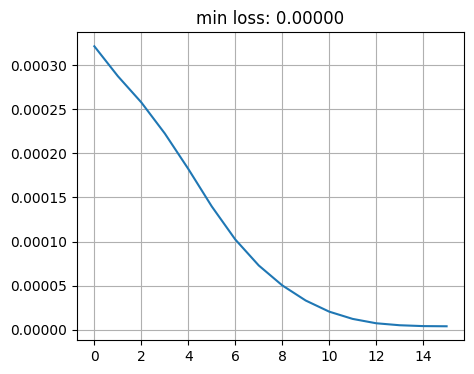

In [27]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(loss_history)
ax.grid()
ax.set_title(f'min loss: {min(loss_history):.5f}')

# тестируем

In [28]:
from random import sample
from nltk.util import ngrams 

prompts = [
        ' '.join(ng) 
        for s in sample( ds.sentences,10 ) 
        if len(s[:-3])>context_len
        for ng in list(ngrams(s[:context_len],5))  
    ]

display( prompts )

['Разумеется , я далеко не',
 'Но кроме того , что',
 'Ибо , хотя он дает',
 '-- Так это же не',
 'И галантность по отношению к',
 'И другой корреспондент `` Свободной',
 '-- А страна , в',
 'Так в тихий предутренний час',
 'Зная это , не так',
 'Тем временем оба моих пассажира']

In [29]:
class LangModelRNN: # генератор текста 
    
    def __init__(self,model):
        self._model = model # языковая модель, предсказывает слово по контексту
        self._vocabulary = model.vocabulary # словарь языковой модели
        self._vocabulary_inv = { v:k for k,v in self._vocabulary.items() }
        self._device = next(model.parameters()).device 
        self._context_len = model.context_len
    
    def predict(self,prompt,seq_limit=10):
        s = prompt
        for _ in range(seq_limit):
            w = self._vocabulary_inv[ self._predict(s) ]
            s = s + ' ' + w
            if w=='<EOS>':break
        return s
        
    def _predict(self,prompt):
        x = self._encode(prompt)
        with torch.set_grad_enabled(False): 
            p = self._model.predict(x.to(device)).cpu()
        return p.item()    
    
    def _encode(self,s):
        s = nltk_tokenize_word(s,language='russian')[-self._context_len:]
        s = [ self._vocabulary[w] for w in s if (w in self._vocabulary) ]
        return torch.tensor([s], dtype=torch.long )

In [30]:
for prompt in prompts:
    t = LangModelRNN(model).predict(prompt,seq_limit=20)
    print(prompt,'-->', t[len(prompt):],'\n')

Разумеется , я далеко не -->  беден , думал швейцар , но , если судить трезво , разве я так богат , чтоб одной рукой платить 

Но кроме того , что -->  он арестован , мы ничего не знали . <EOS> 

Ибо , хотя он дает -->  аэропорты не совсем бесплатно , какой , даже самый строгий босс , решится назвать кусок курицы -- взяткой ? <EOS> 

-- Так это же не -->  меня обыскивают , а вас . <EOS> 

И галантность по отношению к -->  пожилой даме . <EOS> 

И другой корреспондент `` Свободной -->  Европы '' регулировщица : '' За я не стал говорить хозяйке , что знаю ее мужа . <EOS> 

-- А страна , в -->  которой вы теперь живете , вам нравится ? <EOS> 

Так в тихий предутренний час -->  в воскресенье я оказался в движущейся машине -- один ... Было 3 июля , мой день рождения -- самый радостный 

Зная это , не так -->  уж трудно представить себе , с какой миной выслушивает швейцар `` Астории '' обычную '' всего '' РАДИО СВОБОДА '' 

Тем временем оба моих пассажира -->  вылезли из кэба и , услыхав сме